In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

#import src.rna_analysis
from src.KLD_calculation import jsd_loop,markov_matrix,distance_calculation

import sys
import os
sys.path.append("..")

In [2]:
os.getcwd()

'/Volumes/ag_ohler/jdemoli/bachelorgit'

In [3]:
print("Torch version:", torch.__version__)
print("CUDA version in PyTorch:", torch.version.cuda)
print("Is CUDA available:", torch.cuda.is_available())
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No CUDA")

Torch version: 2.6.0
CUDA version in PyTorch: None
Is CUDA available: False
GPU name: No CUDA


In [2]:
# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
scaler = StandardScaler()
#device = torch.device("cpu")

In [6]:
def one_hot(seqs):
    conversion_dict={
        'A':np.array([1.0,0.0,0.0,0.0]),
        'C':np.array([0.0,1.0,0.0,0.0]),
        'G':np.array([0.0,0.0,1.0,0.0]),
        'U':np.array([0.0,0.0,0.0,1.0]),
        'T':np.array([0.0,0.0,0.0,1.0]),
    }
    enc_seqs=[]
    for seq in seqs:
        enc_arr=conversion_dict[seq[0]]
        for i in seq[1:]:
            enc_arr=np.vstack((enc_arr,conversion_dict[i]))
        #enc_arr=enc_arr.T.reshape((1,4,50))
        enc_arr=torch.tensor(enc_arr.T, dtype = torch.float32)
        enc_seqs.append(enc_arr)
    enc_seqs=torch.tensor(np.array(enc_seqs),dtype = torch.float32)
        
    return enc_seqs
        
    

In [7]:
testset1=pd.read_csv('data/random_test.csv')
testset2=pd.read_csv('data/human_test.csv')
testseqs1=one_hot(list(testset1["utr"]))
testseqs2=one_hot(list(testset2["utr"]))

In [9]:
# load data
# FRED: Die Zeile ist unnötig und wird unten überschrieben
dataset1 = pd.read_csv('data/random_train_pc.csv')
trainseqs1 = one_hot(list(dataset1["utr"]))
trainmrl1 = dataset1['rl'].values.reshape([-1,1])
scaledmrl1 = torch.tensor(scaler.fit_transform(trainmrl1).reshape([-1]),dtype = torch.float32)

dataset1_reshaped=list(zip(trainseqs1,scaledmrl1))
batch_size=128
scaler.fit(trainmrl1)
trainloader=torch.utils.data.DataLoader(dataset1_reshaped ,batch_size=batch_size,shuffle=True)

NameError: name 'scaler' is not defined

In [3]:
# Laden der Daten für den Loop
sorted_random_seqs=pd.read_csv('data/JSD_random_seqs.csv')#<-Speicherort
human_train_seqs=pd.read_csv('data/human_train.csv')#<-Speicherort
sorted_random_seqs['Group']=np.array(['random']*len(sorted_random_seqs))
human_train_seqs['Group']=np.array(['human']*len(human_train_seqs))
full_dataset=pd.concat([sorted_random_seqs,human_train_seqs])
fullmrl = full_dataset['rl'].values.reshape([-1,1])
scaler.fit(fullmrl)


StandardScaler()

In [24]:
len(human_train_seqs)

20000

In [10]:
correct_random_mrl=np.array(testset1["rl"])
correct_human_mrl=np.array(testset2["rl"])
batch_size=128

In [11]:
#Validierungsset
human_dataset=pd.read_csv('data/human_val.csv')
humanseqs1=one_hot(list(human_dataset["utr"]))
print(humanseqs1.shape)
humanmrl1=human_dataset['rl'].values.reshape([-1,1])
scaledhumanmrl1=torch.tensor(scaler.transform(humanmrl1).reshape([-1]),dtype = torch.float32)
human_val=list(zip(humanseqs1,scaledhumanmrl1))

valloader=torch.utils.data.DataLoader(human_val,batch_size=batch_size,shuffle=True)

torch.Size([5000, 4, 50])


NameError: name 'scaler' is not defined

5000

In [62]:
sns.set_style('whitegrid')
plt.rc('font',size=14)
fig,ax=plt.subplots(figsize=(8,4.5))
sns.histplot(data=full_dataset,x='rl',bins=50,multiple='layer',hue='Group',stat='probability',common_norm=False,ax=ax)
ax.set_xlabel('MRL')
fig.tight_layout()

In [12]:
class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv1d(4, 120, kernel_size=8, padding='same')
        self.conv2 = nn.Conv1d(120, 120, kernel_size=8, padding='same')
        self.conv3 = nn.Conv1d(120, 120, kernel_size=8, padding='same')
        self.flat1 = nn.Flatten()
        self.fc1 = nn.Linear(6000, 40)
        self.drop1 = nn.Dropout(0.2)
        self.out = nn.Linear(40, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        #print(x.shape)
        x = F.relu(self.conv2(x))
        #print(x.shape)
        x = F.relu(self.conv3(x))
        #print(x.shape)
        x = self.flat1(x)
        #x= torch.transpose(x, 1, 2)
        x = F.relu(self.fc1(x))
        x = self.drop1(x)
        x = self.out(x)
        return x

In [13]:
net=Model()
net.to(device)

Model(
  (conv1): Conv1d(4, 120, kernel_size=(8,), stride=(1,), padding=same)
  (conv2): Conv1d(120, 120, kernel_size=(8,), stride=(1,), padding=same)
  (conv3): Conv1d(120, 120, kernel_size=(8,), stride=(1,), padding=same)
  (flat1): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=6000, out_features=40, bias=True)
  (drop1): Dropout(p=0.2, inplace=False)
  (out): Linear(in_features=40, out_features=1, bias=True)
)

In [14]:
criterion = nn.MSELoss()#(aL-y)^2
optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(0.9,0.999))#epsilon ist standradmäßig bei 1e-8
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

In [15]:
torch.save(net.state_dict(),'models/untrained.pt')#<-Speicherort

In [16]:
def earlystopper(val_loss,patience=10,epsilon=1e-7):
    global es_stopcounter
    global es_min_loss
    if patience >= es_stopcounter: 
        if val_loss <= es_min_loss - epsilon:
            es_min_loss = val_loss
            es_stopcounter = 0
        else:
            es_stopcounter += 1
        return False
    else:
        return True
        
    

In [17]:
def train_one_epoch(epoch,trainloader,valloader):
    net.train(True)
    global loss_plot
    global val_plot
    global batch_plot
    global val_batch_plot
    global es_min_loss
    global min_batch_plot
    global stopcondition

    running_loss = 0.0
    val_running_loss = 0.0
    for batch_index, data in enumerate(trainloader):
        inputs, correct_mrl = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()  # flush gradient
        outputs = net(inputs)  # shape:
        outputs = torch.reshape(outputs, (-1,))
        loss = criterion(outputs, correct_mrl)
        loss_plot.append(loss.item())
        batch_plot.append(batch_index+1+epoch*len(trainloader))
        loss.backward()
        optimizer.step()

        
        for val_batch_index, val_data in enumerate(valloader):
            val_inputs, val_correct_mrl = val_data[0].to(device), val_data[1].to(device)
            val_outputs = net(val_inputs)
            val_outputs = torch.reshape(val_outputs, (-1,))
            val_loss = criterion(val_outputs, val_correct_mrl)
            val_running_loss += val_loss.item()
        val_mean_loss=val_running_loss/len(valloader)
        val_plot.append(val_mean_loss)
        val_batch_plot.append(batch_index+1+epoch*len(trainloader))
        val_running_loss = 0.0
        tmp_min=es_min_loss
        if earlystopper(val_mean_loss,patience=len(trainloader),epsilon=1e-4):
            print(f'Stopping at epoch {epoch+1}, batch {batch_index+1}')
            stopcondition = False
            break
        if es_min_loss!=tmp_min:
            min_batch_plot.append(batch_index+1+epoch*len(trainloader))
            minimum_plot.append(es_min_loss)




In [18]:
untrained_random_mrl=net(testseqs1.to(device)).cpu().detach().numpy().reshape(-1,)
untrained_human_mrl=net(testseqs2.to(device)).cpu().detach().numpy().reshape(-1,)

/fast/home/j/jdemoli/miniforge3/envs/modelenv/lib/python3.10/site-packages/torch/nn/modules/conv.py:370: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /opt/conda/conda-bld/pytorch_1728929546833/work/aten/src/ATen/native/Convolution.cpp:1036.)
  return F.conv1d(


In [19]:
net.load_state_dict(torch.load("models/untrained.pt",weights_only=False))
print('done')

done


In [20]:
batch_plot=[]
loss_plot=[]
val_plot=[]
val_batch_plot=[]
es_stopcounter = 0
es_min_loss=np.inf
minimum_plot=[]
min_batch_plot=[]
stopcondition=True
epoch=0
while stopcondition:
    print(f'Epoch {epoch+1}')
    train_one_epoch(epoch,trainloader,valloader)
    epoch+=1
print('done')

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Stopping at epoch 4, batch 387
done


In [ ]:
r2_rt_plot=[]
r2_ht_plot=[]

#New training loop
for i in np.arange(0,1.1,0.1):
    net = Model().to(device)
    net.load_state_dict(torch.load("models/untrained.pt",weights_only=False))
    optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(0.9,0.999)) # fresh optimizer
    if i<=0.0:
        nextstep_dataset=human_train_seqs.loc[0:9999]
    elif i==1.0:
        nextstep_dataset=pd.concat([human_train_seqs.loc[0:9999],sorted_random_seqs.loc[0:len(sorted_random_seqs)-1]],ignore_index=True)
    else:  
        nextstep_dataset=pd.concat([human_train_seqs.loc[0:9999],sorted_random_seqs.loc[0:int(i*len(sorted_random_seqs)-1)]],ignore_index=True)
    nextstep_seqs=one_hot(list(nextstep_dataset['utr']))
    print(f'shape of trainingset: {nextstep_seqs.shape}')
    nexstep_mrl=nextstep_dataset['rl'].values.reshape([-1,1])
    nextstep_scaled_mrl=torch.tensor(scaler.transform(nexstep_mrl).reshape([-1]),dtype = torch.float32)
    nextstep_train=list(zip(nextstep_seqs,nextstep_scaled_mrl))
    trainloader=torch.utils.data.DataLoader(nextstep_train,batch_size=batch_size,shuffle=True)
    
    #Actual Training
    batch_plot = []
    loss_plot = []
    val_plot = []
    val_batch_plot = []
    es_stopcounter = 0
    es_min_loss = np.inf
    minimum_plot = []
    min_batch_plot = []
    stopcondition=True
    epoch=0
    print(f'Dataset = Human(10000) + {int(i*100)}% JSD sampled({int(i*len(sorted_random_seqs))})')
    while stopcondition:
        train_one_epoch(epoch,trainloader,valloader)
        epoch+=1

    
    torch.save(net.state_dict(),f'models/models_run02/JSD_trained_h{int(i*100)}.pt')#<-Speicherort

    #Getting the outputs of network
    trained_scaled_random_mrl = net(testseqs1.to(device)).cpu().detach().numpy().reshape(-1, )
    trained_scaled_human_mrl = net(testseqs2.to(device)).cpu().detach().numpy().reshape(-1, )
    trained_random_mrl = scaler.inverse_transform(trained_scaled_random_mrl.reshape([-1, 1])).reshape(-1, )
    trained_human_mrl = scaler.inverse_transform(trained_scaled_human_mrl.reshape([-1, 1])).reshape(-1, )
    
    #recording R^2
    hr2=pearsonr(correct_human_mrl,trained_human_mrl)[0]**2
    print('R^2 of random seqs',hr2)
    r2_ht_plot.append(hr2)
    rr2=pearsonr(correct_random_mrl,trained_random_mrl)[0]**2
    print('R^2 of human seqs',rr2)
    r2_rt_plot.append(rr2)
    if hr2==np.nan or rr2==np.nan or hr2<=0.2 or rr2<=0.2:
        pickle.dump([batch_plot,val_batch_plot,loss_plot,val_plot,minimum_plot,min_batch_plot], open(f'models/models_run02/brokentraining_h{int(i*100)}.pkl', 'wb'))#<-Speicherort
        print(f'Model broke at {int(i*100)}% of sampled seqs')


In [ ]:
pickle.dump([r2_ht_plot,r2_rt_plot], open('models/models_run01/r2_plot.pkl', 'wb'))

In [4]:
r2_sampled_plots= pickle.load(open('models/models_run04/r2_plot_sampled_data.pkl', 'rb'))
r2_sampled_ht_plot=np.array(r2_sampled_plots[0])
r2_sampled_rt_plot=np.array(r2_sampled_plots[1])

r2_shuffled_plots = pickle.load(open('models/models_run05/r2_plot_unsampled_data.pkl', 'rb'))
r2_shuffled_ht_plot=np.array(r2_shuffled_plots[0])
r2_shuffled_rt_plot=np.array(r2_shuffled_plots[1])


In [5]:
r2_sampled_ht_mean=np.mean(r2_sampled_ht_plot,axis=1)
r2_sampled_rt_mean=np.mean(r2_sampled_rt_plot,axis=1)

r2_sampled_ht_std=np.std(r2_sampled_ht_plot,axis=1)
r2_sampled_rt_std=np.std(r2_sampled_rt_plot,axis=1)

r2_shuffled_ht_mean=np.mean(r2_shuffled_ht_plot,axis=1)
r2_shuffled_rt_mean=np.mean(r2_shuffled_rt_plot,axis=1)

r2_shuffled_ht_std=np.std(r2_shuffled_ht_plot,axis=1)
r2_shuffled_rt_std=np.std(r2_shuffled_rt_plot,axis=1)


In [46]:
plot_xticks=[f'{i*10}%' for i in range(11)]
len(plot_xticks)

11

In [8]:
%matplotlib qt
sns.set_style('whitegrid')
plt.rc('font',size=18)
fig,ax=plt.subplots(figsize=(16,9))
labels=['R$^2$ on human test set, JSD sampled','R$^2$ on random test set, JSD sampled','R$^2$ on human test set, no sampling','R$^2$ on human test set, no sampling']
sns.lineplot(x=np.arange(0,len(r2_sampled_ht_mean),1),y=r2_sampled_ht_mean,label='R$^2$ on human test set, JSD sampled',marker='.',color=sns.color_palette('Blues')[-2],ax=ax)
sns.lineplot(x=np.arange(0,len(r2_sampled_rt_mean),1),y=r2_sampled_rt_mean,label='R$^2$ on random test set, JSD sampled',marker='.',color=sns.color_palette('Oranges')[-2],ax=ax)
ax.errorbar(np.arange(0,len(r2_sampled_ht_mean),1),r2_sampled_ht_mean,r2_sampled_ht_std,color=sns.color_palette('Blues')[-2],capsize=3)
ax.errorbar(np.arange(0,len(r2_sampled_rt_mean),1),r2_sampled_rt_mean,r2_sampled_rt_std,color=sns.color_palette('Oranges')[-2],capsize=3)

sns.lineplot(x=np.arange(0,len(r2_shuffled_ht_mean),1),y=r2_shuffled_ht_mean,label='R$^2$ on human test set, no sampling',marker='.',color=sns.color_palette('Blues')[2],ax=ax)
sns.lineplot(x=np.arange(0,len(r2_shuffled_rt_mean),1),y=r2_shuffled_rt_mean,label='R$^2$ on random test set, no sampling',marker='.',color=sns.color_palette('Oranges')[2],ax=ax)
ax.errorbar(np.arange(0,len(r2_shuffled_ht_mean),1),r2_shuffled_ht_mean,r2_shuffled_ht_std,color=sns.color_palette('Blues')[2],capsize=3)
ax.errorbar(np.arange(0,len(r2_shuffled_rt_mean),1),r2_shuffled_rt_mean,r2_shuffled_rt_std,color=sns.color_palette('Oranges')[2],capsize=3)
legend = ax.get_legend()
handles=legend.legend_handles
ax.legend(handles=handles,labels=labels,fontsize=16,loc='upper left')
ax.vlines(np.arange(0,len(r2_sampled_ht_mean),1),0,1,linestyles='dashed',alpha=0.1)
plot_xticks=[f'{i*10}%' for i in range(11)]
ax.set_xlabel('Percent of complete random dataset')
ax.set_ylabel('R$^2$ of predicted vs. trained mrl')
ax.set_ylim([0.5,1])
ax.set_xticks(np.arange(0,len(r2_sampled_rt_mean),1),plot_xticks)
fig.tight_layout()
plt.show()

# Bis hierhin ausführen, ab hier noch WIP
(Probleme mit Datenstrukturen)

In [20]:
shuffled_dataset=dataset1.copy(deep=True).sample(frac=1,random_state=1).reset_index(drop=True)

In [21]:
len(shuffled_dataset.iloc[0:len(shuffled_dataset)])


260000

In [22]:
alt_r2_ht_plot=[]
alt_r2_rt_plot=[]

#Comparison training loop
for i in np.arange(0,1.1,0.1):
    net.load_state_dict(torch.load("models/untrained.pt",weights_only=False))
    #Generate Training dataset
    #10% of randomseqs every iteration
    nextstep_dataset=pd.concat([human_train_seqs,shuffled_dataset.loc[0:int(i*len(shuffled_dataset))]],ignore_index=True)
    
        
    nextstep_seqs=one_hot(list(nextstep_dataset['utr']))
    print(f'shape of trainingset: {nextstep_seqs.shape}')
    nexstep_mrl=nextstep_dataset['rl'].values.reshape([-1,1])
    nextstep_scaled_mrl=torch.tensor(scaler.transform(nexstep_mrl).reshape([-1]),dtype = torch.float32)
    print(f'shape of mrl: {nexstep_mrl.shape}')
    nextstep_train=list(zip(nextstep_seqs,nextstep_scaled_mrl))
    trainloader=torch.utils.data.DataLoader(nextstep_train,batch_size=batch_size,shuffle=True)
    
    #Actual Training
    batch_plot=[]
    loss_plot=[]
    val_plot=[]
    val_batch_plot=[]
    es_stopcounter = 0
    es_min_loss=np.inf
    minimum_plot=[]
    min_batch_plot=[]
    stopcondition=True
    epoch=0
    print(f'Dataset = Human(20000) + {int(i*100)}% JSD sampled({int(i*len(sorted_random_seqs))})')
    while stopcondition:
        train_one_epoch(epoch,trainloader,valloader)
        epoch+=1
        
    torch.save(net.state_dict(),f'models/Random_trained_h{int(i*100)}.pt')
        

    #Getting the outputs of network
    trained_scaled_random_mrl = net(testseqs1.to(device)).cpu().detach().numpy().reshape(-1, )
    trained_scaled_human_mrl = net(testseqs2.to(device)).cpu().detach().numpy().reshape(-1, )
    trained_random_mrl = scaler.inverse_transform(trained_scaled_random_mrl.reshape([-1, 1])).reshape(-1, )
    trained_human_mrl = scaler.inverse_transform(trained_scaled_human_mrl.reshape([-1, 1])).reshape(-1, )
    
    #recording R^2
    hr2=pearsonr(correct_human_mrl,trained_human_mrl)[0]**2
    print('R^2 of random seqs',hr2)
    alt_r2_ht_plot.append(hr2)
    rr2=pearsonr(correct_random_mrl,trained_random_mrl)[0]**2
    print('R^2 of human seqs',rr2)
    alt_r2_rt_plot.append(rr2)


shape of trainingset: torch.Size([20001, 4, 50])
shape of mrl: (20001, 1)
Dataset = Human(20000) + 0% JSD sampled(0)


/fast/home/j/jdemoli/miniforge3/envs/modelenv/lib/python3.10/site-packages/torch/nn/modules/conv.py:370: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /opt/conda/conda-bld/pytorch_1728929546833/work/aten/src/ATen/native/Convolution.cpp:1036.)
  return F.conv1d(


Stopping at epoch 24, batch 31
R^2 of random seqs 0.7843525966048266
R^2 of human seqs 0.6304311186328336
shape of trainingset: torch.Size([46001, 4, 50])
shape of mrl: (46001, 1)
Dataset = Human(20000) + 10% JSD sampled(26000)
Stopping at epoch 4, batch 121
R^2 of random seqs 0.6286936105653849
R^2 of human seqs 0.6862737093903625
shape of trainingset: torch.Size([72001, 4, 50])
shape of mrl: (72001, 1)
Dataset = Human(20000) + 20% JSD sampled(52000)
Stopping at epoch 2, batch 304
R^2 of random seqs 0.5648022245808989
R^2 of human seqs 0.6702744795212903
shape of trainingset: torch.Size([98001, 4, 50])
shape of mrl: (98001, 1)
Dataset = Human(20000) + 30% JSD sampled(78000)
Stopping at epoch 17, batch 64
R^2 of random seqs 0.7167286132438441
R^2 of human seqs 0.7783969735570074
shape of trainingset: torch.Size([124001, 4, 50])
shape of mrl: (124001, 1)
Dataset = Human(20000) + 40% JSD sampled(104000)
Stopping at epoch 2, batch 931
R^2 of random seqs 0.669842470694738
R^2 of human seqs

KeyboardInterrupt: 

In [ ]:
sns.lineplot(x=np.arange(0,len(r2_ht_plot),1),y=r2_ht_plot,label='R$^2$ of human seqs',marker='+',color='#d31f11')
sns.lineplot(x=np.arange(0,len(r2_rt_plot),1),y=r2_rt_plot,label='R$^2$ of random seqs',marker='*',color='#007191')

#sns.lineplot(x=np.arange(0,len(alt_r2_ht_plot),1),y=alt_r2_ht_plot,label='R$^2$ of human seqs',marker='+',color='#f47a00')
#sns.lineplot(x=np.arange(0,len(alt_r2_rt_plot),1),y=alt_r2_rt_plot,label='R$^2$ of random seqs',marker='*',color='#62c8d3')

plt.vlines(np.arange(0,len(r2_ht_plot),1),0,1,linestyles='dashed',alpha=0.5)
plot_xticks=[f'Human + {i*10}%' for i in range(11)]
plt.xticks(np.arange(0,len(r2_rt_plot),1),plot_xticks,rotation=-60)
plt.show()
#,color='#d31f11',color='#f47a00',color='#007191',color='#62c8d3'

# Ab hier nur Plots

In [29]:
plot_val=pickle.load(open('models/models_run02/trainingplot_h10.pkl','rb'))
batch_plot=plot_val[0]
val_batch_plot=plot_val[1]
loss_plot=plot_val[2]
val_plot=plot_val[3]

FileNotFoundError: [Errno 2] No such file or directory: 'models/models_run02/trainingplot_h0.pkl'

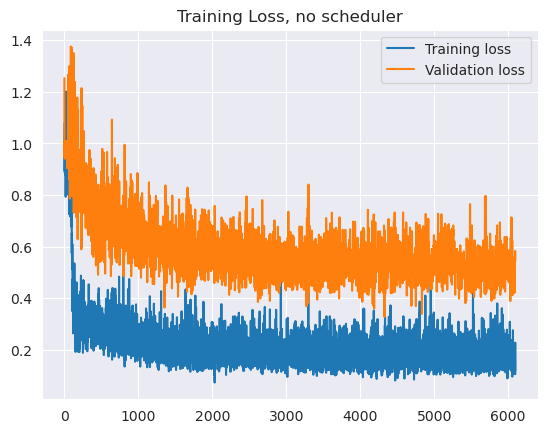

In [19]:
%matplotlib inline
plt.plot(batch_plot,loss_plot,label='Training loss')
plt.plot(val_batch_plot,val_plot,label='Validation loss')
#plt.vlines(np.arange(0,len(batch_plot)+10,int(len(human_train_seqs)/128+len(sorted_random_seqs)/128)),0,4.3,linestyles='dashed',alpha=0.3,color='grey')
#plt.plot(min_batch_plot,minimum_plot,linestyle='none',marker='+',label='Minimum validation')
#plt.xlim()
plt.legend()
plt.title(f'Training Loss, no scheduler')
plt.show()

In [ ]:
len(batch_plot)/3

In [ ]:
torch.save(net.state_dict(),'data/random_noscheduler.pt')

In [ ]:
torch.load("data/random_unval.pt",)

# Plotsektion

In [ ]:
net.load_state_dict(torch.load('data/random_unval.pt',weights_only=True))

In [37]:
net.load_state_dict(torch.load('models/models_run02/JSD_trained_h100.pt',weights_only=False))

<All keys matched successfully>

In [22]:
trained_random_mrl=net(testseqs1.to(device)).cpu().detach().numpy().reshape(-1,)
trained_human_mrl=net(testseqs2.to(device)).cpu().detach().numpy().reshape(-1,)

In [23]:
trained_random_mrl = scaler.inverse_transform(trained_random_mrl.reshape([-1,1])).reshape(-1,)
trained_human_mrl = scaler.inverse_transform(trained_human_mrl.reshape([-1,1])).reshape(-1,)

Text(0.5, 1.0, 'trained model mrl prediction on humandata')

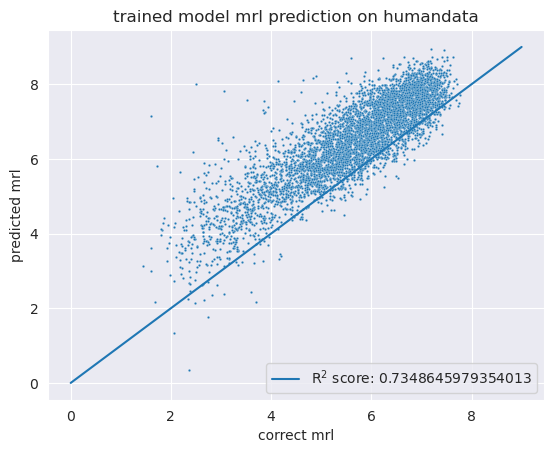

In [18]:
%matplotlib inline
sns.scatterplot(x=correct_human_mrl,y=trained_human_mrl,s=3)
sns.lineplot(x=np.linspace(0,9,num=10),y=np.linspace(0,9,num=10),label=f'R$^2$ score: {pearsonr(correct_human_mrl,trained_human_mrl)[0]**2}')
#plt.hlines(xmin=0,xmax=9,y=full_dataset['rl'].mean(),color='red')
#plt.xlim(0,10)
#plt.ylim(0,10)
plt.xlabel("correct mrl")
plt.ylabel("predicted mrl")
plt.legend(loc='lower right')
plt.title(f"trained model mrl prediction on humandata")

In [24]:
pickle.dump([batch_plot,loss_plot,val_batch_plot,val_plot,trained_human_mrl,trained_random_mrl],open('data/modelplot.pkl','wb'))


In [11]:
modelplot_variables=pickle.load(open('data/modelplot.pkl','rb'))
batch_plot=modelplot_variables[0]
loss_plot=modelplot_variables[1]
val_batch_plot=modelplot_variables[2]
val_plot=modelplot_variables[3]
trained_human_mrl=modelplot_variables[4]
trained_random_mrl=modelplot_variables[5]

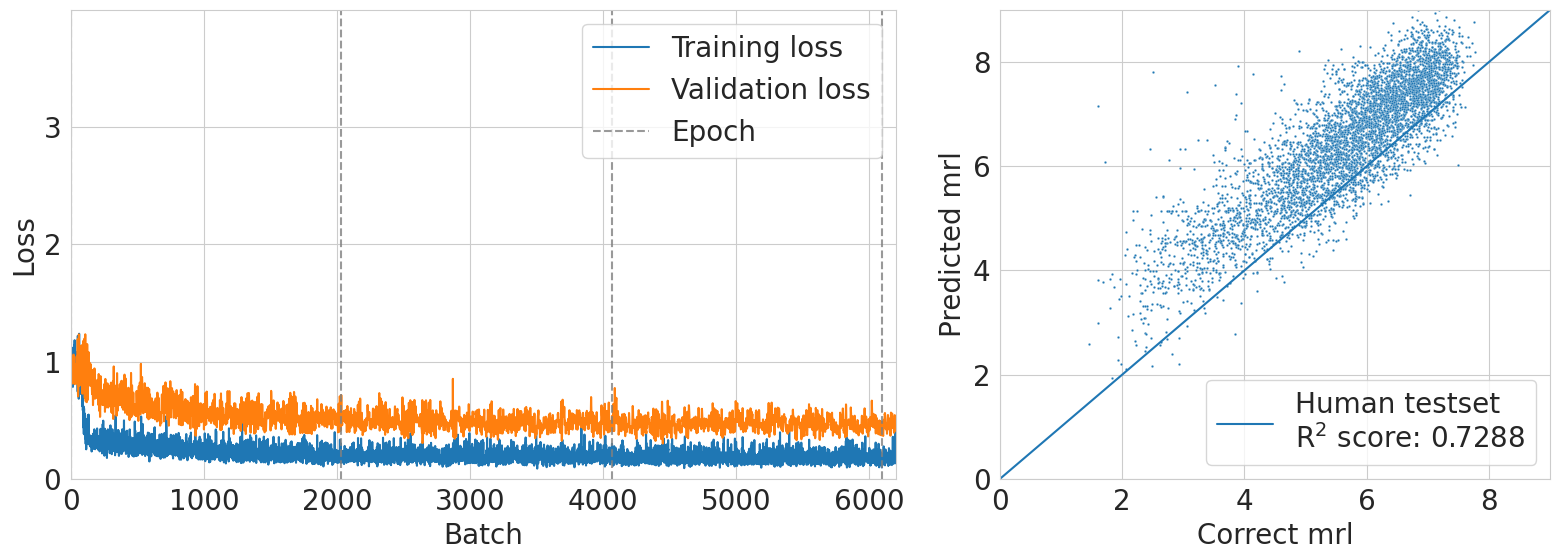

In [25]:
%matplotlib inline
plt.rc('font',size=20)
sns.set_style("whitegrid")
fig, axs = plt.subplots(1,2,gridspec_kw={'width_ratios':[3,2]}, figsize=(16,6))
sns.lineplot(x=batch_plot,y=loss_plot,label='Training loss',ax=axs[0])
sns.lineplot(x=val_batch_plot,y=val_plot,label='Validation loss',ax=axs[0])
axs[0].vlines(np.arange(0,len(batch_plot)+10,int(len(trainloader))),0,4.3,linestyles='dashed',alpha=0.8,color='grey',label='Epoch')
axs[0].set_xlabel('Batch',size=20)
axs[0].set_ylabel('Loss',size=20)
axs[0].set_xlim([0,6200])
axs[0].set_ylim([0,4])
axs[0].set_yticks([0,1,2,3])
axs[0].legend()

sns.scatterplot(x=correct_human_mrl,y=trained_human_mrl,s=3,ax=axs[1])
sns.lineplot(x=np.linspace(0,9,num=10),y=np.linspace(0,9,num=10),label=f'Human testset\nR$^2$ score: {round(pearsonr(correct_human_mrl,trained_human_mrl)[0]**2,4)}')
axs[1].set_xlabel('Correct mrl',size=20)
axs[1].set_ylabel('Predicted mrl',size=20)
axs[1].set_xlim([0,9])
axs[1].set_xticks([0,2,4,6,8])
axs[1].set_ylim([0,9])
axs[1].set_yticks([0,2,4,6,8])


fig.tight_layout()
plt.show()

In [38]:
.trained_random_mrl[0:10]

array([6.4724035, 6.4724345, 6.469776 , 6.4724035, 6.4724035, 6.467547 ,
       6.4724355, 6.4724345, 6.469776 , 6.4724035], dtype=float32)

In [ ]:
plt.plot(np.arange(1,20001,1),untrained_random_mrl,linestyle='None',marker='o',color='blue',markersize=1)
plt.plot(np.arange(1,20001,1),correct_random_mrl,linestyle='None',marker='o',color='red',markersize=1)


In [ ]:
min(batch_plot)

In [ ]:
epoch=0
for i in range(len(batch_plot)):
    batch_plot[i]=batch_plot[i]+epoch*1981
    print(batch_plot[i])
    if batch_plot[i] == 1981:
        epoch+=1
        

In [ ]:
sns.lineplot(x=np.arange(1,302941,1),y=val_plot)
sns.lineplot(x=np.arange(1,302941,1),y=batch_plot)
plt.xlim(0,153)
plt.ylim(0,50)

In [ ]:
%matplotlib qt
plt.plot(batch_plot,loss_plot, color='blue',markersize=1,label='Loss')
plt.plot(val_batch_plot,val_plot, color='orange',markersize=1,label='Validation')
plt.title('Loss vs Batch')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.show()

In [ ]:
avg_loss=[]
running_loss=0
for i in range(len(loss_plot)):
    running_loss+=loss_plot[i]
    if i%30==29:
        avg_loss.append(running_loss/30)
        running_loss=0
len(avg_loss)

In [ ]:
avg_val_loss=[]
avg_batch_plot=[]
val_running_loss=0
for i in range(len(val_plot)):
    val_running_loss+=val_plot[i]
    if i%10==9:
        avg_val_loss.append(val_running_loss/10)
        avg_batch_plot.append(val_x[i])
        val_running_loss=0
len(avg_val_loss)

In [ ]:

plt.plot(avg_batch_plot,avg_loss, color='blue',markersize=1,label='Loss')
plt.plot(avg_batch_plot,avg_val_loss, color='orange',markersize=1,label='Validation')
plt.title('Loss vs Batch')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#batch_plot=[500,1000,1500,2000,2500,3000,3500,4000,4500,5000,5500,6000]
#plt.plot(batch_plot,loss_plot)

print((len(trainloader)-1) %200)

# JSD-Sampling

In [9]:
random_seqs=pd.read_csv('data/random_train_pc.csv')
my_random_seqs=pd.read_csv('data/random_50nt_seqs.csv')
sample_data = pd.read_csv("data/human_sample.csv")
reference_data = pd.concat([sample_data,human_train_seqs],axis=0,ignore_index=True)
for i in reference_data.index:
    reference_data.loc[i, 'utr'] = reference_data.loc[i, 'utr'].replace('T', 'U')

#reference_seqs = reference_data.loc[reference_data['Group'] == 'Human']
human_matrix=markov_matrix(reference_data,"utr")[2]


In [10]:
len(reference_data)

40600

In [11]:
human_jsd2=jsd_loop(reference_data,"utr",human_matrix,a=2)
human_jsd=jsd_loop(reference_data,"utr",human_matrix,a=1)
human_jsd05=jsd_loop(reference_data,"utr",human_matrix,a=0.5)
human_jsd16=jsd_loop(reference_data,"utr",human_matrix,a=0.0625)



In [12]:
random_jsd2=jsd_loop(random_seqs,"utr",human_matrix,a=2)
random_jsd=jsd_loop(random_seqs,"utr",human_matrix,a=1)
random_jsd05=jsd_loop(random_seqs,"utr",human_matrix,a=0.5)
random_jsd16=jsd_loop(random_seqs,"utr",human_matrix,a=0.0625)

my_random_jsd=jsd_loop(my_random_seqs,"Sequence",human_matrix,a=1)
my_random_jsd16=jsd_loop(my_random_seqs,"Sequence",human_matrix,a=0.0625)

In [16]:
reference_data['JSD']=human_jsd
random_seqs['JSD']=random_jsd

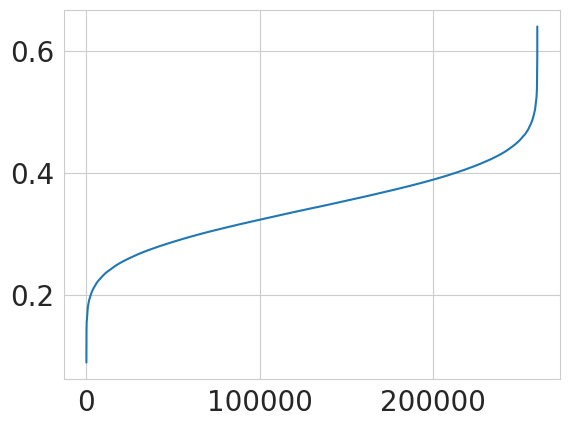

In [58]:
plt.plot(np.arange(0,len(sorted_random_seqs),1),sorted_random_seqs['JSD'].values)

In [13]:
#human_cross_jsd=pickle.load(open('data/human_jsd.pkl','rb'))
human_cross_jsd=np.load('data/human_jsd.npy')
len(human_cross_jsd)

400000000

In [14]:
bins=np.arange(0.1,0.81,0.01)
print(bins)

[0.1  0.11 0.12 0.13 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23
 0.24 0.25 0.26 0.27 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37
 0.38 0.39 0.4  0.41 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51
 0.52 0.53 0.54 0.55 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65
 0.66 0.67 0.68 0.69 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79
 0.8 ]


In [61]:
human_percentile=np.percentile(human_jsd,90)
human_percentile

np.float64(0.4030568585409065)

In [15]:
human_cross_jsd=np.sort(human_cross_jsd)
human_cjsd_subset=np.random.choice(human_cross_jsd,size=10000000)


In [16]:
%matplotlib qt
sns.set_style('whitegrid')
plt.rc('font',size=20)
fig, ax = plt.subplots(figsize=(10,8))
sns.histplot(x=human_jsd,bins=bins,stat='probability',label='Human to Human-matrix',common_norm=False,color=sns.color_palette()[0],alpha=0.8,kde=True,ax=ax)
sns.histplot(x=random_jsd,bins=bins,stat='probability',label='Random to Human-matrix',common_norm=False,color=sns.color_palette()[1],alpha=0.8,kde=True,ax=ax)
sns.histplot(x=human_cjsd_subset,bins=bins,stat='probability',label='Human pairwise ',common_norm=False,color='#788aa3',alpha=0.8,kde=True,ax=ax)


ax.set_ylim([0,0.065])

ax.set_xlabel("Jennsen-Shannon Distance",fontsize=22)
ax.set_ylabel("Probability",fontsize=22)
#ax.set_title("Comparison of JSD, a=1",fontsize=22)
ax.legend()
fig.tight_layout()
plt.show()

In [ ]:
%matplotlib inline
sns.histplot(np.array(np.sqrt(human_jsd)),bins=bins,stat='probability',label='Human')
sns.histplot(np.array(random_jsd),bins=bins,stat='probability',label='Random')
plt.vlines(human_percentile,0,0.07,colors='red')
#plt.xlim([0,0.3])
plt.ylim([0,0.07])
plt.legend()
plt.show()

In [ ]:
jsd_sampled_seqs=random_seqs[random_seqs['JSD']<human_percentile]
print(len(jsd_sampled_seqs)/len(random_seqs))
my_data = pd.read_csv("data/new_dataset.csv")
my_seqs = my_data.loc[my_data['Group'] == 'Human']
my_matrix = markov_matrix(my_seqs,"Sequence")[2]
my_jsd=jsd_loop(my_seqs,"Sequence",my_matrix,a=1)
my_random_jsd=jsd_loop(random_seqs,"utr",my_matrix,a=1)

In [26]:
%matplotlib qt
sns.set_style('whitegrid')
plt.rc('font',size=20)
fig, ax = plt.subplots(figsize=(10,8))
sns.set_palette(sns.color_palette('Set2'))
sns.kdeplot(human_jsd2,label='Pseudocount=2',ax=ax)
sns.kdeplot(human_jsd,label='Pseudocount=1',ax=ax)
sns.kdeplot(human_jsd05,label='Pseudocount=1/2',ax=ax)
sns.kdeplot(human_jsd16,label='Pseudocount=1/16',ax=ax)
ax.legend(loc='best',fontsize=18)
ax.set_xlabel('Jennsen-Shannon distance')
#plt.title('JSD distributions different pseudocounts')
fig.tight_layout()
plt.show()


In [10]:
%matplotlib inline
sns.kdeplot(human_jsd,label='Pseudocount=1')
sns.kdeplot(human_jsd2,label='Pseudocount=2')
sns.kdeplot(human_jsd05,label='Pseudocount=0.5')
sns.kdeplot(human_jsd01,label='Pseudocount=0.1')
sns.kdeplot(human_jsd16,label='Pseudocount= 1/16')#
sns.kdeplot(human_jsd001,label='Pseudocount=0.01')
plt.legend(loc='best')
plt.title('JSD distributions with different pseudocounts')
plt.show()

NameError: name 'human_jsd01' is not defined

In [ ]:
sns.histplot(np.array(my_jsd),bins=bins,stat='probability',label='Human')
sns.histplot(np.array(my_random_jsd),bins=bins,stat='probability',label='Random')
#plt.xlim([0,0.3])
plt.legend()
plt.show()

In [2]:
reference_data=pd.read_csv("data/human_sample.csv")
q_data=pd.read_csv("data/random_train.csv")
results=distance_calculation(reference_data,q_data,'utr','utr',100)
human_dist=results[0]
random_dists=results[1]

KeyboardInterrupt: 

In [31]:
def GC_Content(seq):
    """Calculates the GC content of a DNA or RNA sequence"""
    return (seq.count('G')+seq.count('C'))/len(seq)

In [34]:
exp_humanseqs=pd.read_csv('data/50nt_human_utrs_filtered.tsv',sep='\t')
exp_humanseqs.sort_values('total',ascending=False)

,Unnamed: 0,utr,rl,library,total
0,0,CCCACCCCGGGCTCTCTCCTGGCCTCCCACCCCCGCGCCCGGCTTC...,4.823082,snv,22646
1,2,CCGTTCCTCCCCGCAGTCCTTCCCCTCCACTCCCTTCCCCTTCTCT...,6.252208,human_utrs,21385
2,4,CCTCTGCCCGCCGTTCTGCTCGCTCGCTCCCCGCTCTGGAGTCTGC...,5.835379,human_utrs,19904
3,5,CCGGCCCCGAGGGCAGGCTCTCCCCGGAGGCTCAGCCCCCTCTGCT...,5.433105,human_utrs,16449
4,6,CGCCCCACCCCATCCTCCTGCCTTCCCGCGCTCCGGTGTCCCCCGC...,4.534654,snv,15527
...,...,...,...,...,...
50564,52955,CCGGAACAGTGACTCACTTATTCAAGATAACTGAAAACATTGGTTG...,6.611121,human_utrs,100
50563,52953,CAGCGGCTCCAGGGACTCTTGGGGAGCAGTGGGGAAAGTGCCGAAC...,6.189598,snv,100
50562,52952,CCGCGAGGCCTTGATCTGCAGGCTTTTGCAGGGGAAGGAGTGGGGC...,7.723234,human_utrs,100
50561,52950,CCCCTCCGTTCCCAGCCTGCCCTGCCCCCGCCTCCTTCCCCTCCTA...,7.214789,human_utrs,100


In [35]:
test_data=exp_humanseqs[0:5000]
print(test_data)

      Unnamed: 0                                                utr        rl  \
0              0  CCCACCCCGGGCTCTCTCCTGGCCTCCCACCCCCGCGCCCGGCTTC...  4.823082   
1              2  CCGTTCCTCCCCGCAGTCCTTCCCCTCCACTCCCTTCCCCTTCTCT...  6.252208   
2              4  CCTCTGCCCGCCGTTCTGCTCGCTCGCTCCCCGCTCTGGAGTCTGC...  5.835379   
3              5  CCGGCCCCGAGGGCAGGCTCTCCCCGGAGGCTCAGCCCCCTCTGCT...  5.433105   
4              6  CGCCCCACCCCATCCTCCTGCCTTCCCGCGCTCCGGTGTCCCCCGC...  4.534654   
...          ...                                                ...       ...   
4995        9722  GCCTCACGGCTCCTGTCTCCCCTCCCTCCTTCTCTCTCACGCCTAG...  6.884808   
4996        9723  CCGGAGCTATTGGGAGTGGCGGATCCTCCCACCCCAGCCGGATCTG...  5.870896   
4997        9729  ACTGGAACTACCTGACCATCTGCCAGCTGTGCCGCCCCTGTGACCC...  6.944855   
4998        9732  AGCGACCGCGGCGGCTGGAACCCTGATTGCTGTCCTTCAACGTGTT...  6.748308   
4999        9735  GTTTGGCCCCCCACCCCGTCGCTTTTCCGTTTCTGGTAGTTGTGCT...  6.562343   

         library  total  
0

In [36]:
train_data=exp_humanseqs[5000:25000]
len(train_data)

20000

In [37]:
val_data=exp_humanseqs[25000:30000]
len(val_data)

5000

In [20]:
len(testset1)

20000

In [38]:
sample_data=exp_humanseqs[30000:]
len(sample_data)

20600

In [22]:
test_data.to_csv('data/human_test.csv')
train_data.to_csv('data/human_train.csv')
val_data.to_csv('data/human_val.csv')
sample_data.to_csv('data/human_sample.csv')


In [49]:
tot_GC=0
for i in dataset1['utr']:
    tot_GC+=GC_Content(i)
print(tot_GC/len(dataset1))
    

0.50057046153846
